### Lab 2 - TSP CITIES

In [31]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
from matplotlib import pyplot as plt
from itertools import accumulate
from tqdm.auto import tqdm
from dataclasses import dataclass

### INITIALIZATION

In [32]:
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
distance_matrix = np.zeros((len(CITIES), len(CITIES)))
for c1,c2 in combinations(CITIES.itertuples(),2):
    distance_matrix[c1[0], c2[0]] = geopy.distance.distance((c1[2], c1[3]), (c2[2], c2[3])).km
    #valid also for c2,c1
    distance_matrix[c2[0], c1[0]] = distance_matrix[c1[0], c2[0]]

MAX_STEPS=5000

## helper funtions

In [33]:
#look for the closest city among the ones that are not visited yet
def find_closest(distance_matrix, city, visited):
    for i in np.argsort(distance_matrix[city]):
        if not visited[i] and i != city:
            return i

def compute_distance(tsp, distance_matrix):
    if set(tsp) == set(range(len(CITIES))):#the first and last city must be the same and all cities must be visited
        return sum([distance_matrix[tsp[i], tsp[i+1]] for i in range(len(tsp)-1)])+distance_matrix[tsp[-1], tsp[0]]
    else:
        return np.inf

def plot_history(history):
    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, min)),
        color="red",
    )
    _ = plt.scatter(range(len(history)), history, marker=".")

### TSP

## Greedy Solution

In [34]:
city=0
visited = np.zeros(len(CITIES), dtype=bool)
visited[city] = True
tsp=[city]
while not all(visited):
    closest = find_closest(distance_matrix, city, visited)
    print(
        f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({distance_matrix[city,closest]:.2f}km)"
    )
    visited[closest] = True
    city = closest
    tsp.append(closest)
print(
    f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({distance_matrix[tsp[-1],tsp[0]]:.2f}km)"
)

tsp_distance = compute_distance(tsp, distance_matrix)
print(f"Total Cost: {tsp_distance:.2f}km")
print(f"Total Steps: {len(tsp)-1}")



step: Ancona -> Rimini (90.60km)
step: Rimini -> Forlì (46.72km)
step: Forlì -> Ravenna (26.46km)
step: Ravenna -> Ferrara (66.67km)
step: Ferrara -> Bologna (43.43km)
step: Bologna -> Modena (37.29km)
step: Modena -> Reggio nell'Emilia (23.94km)
step: Reggio nell'Emilia -> Parma (26.94km)
step: Parma -> Piacenza (57.65km)
step: Piacenza -> Milan (60.65km)
step: Milan -> Monza (14.51km)
step: Monza -> Bergamo (33.92km)
step: Bergamo -> Brescia (46.02km)
step: Brescia -> Verona (61.42km)
step: Verona -> Vicenza (44.70km)
step: Vicenza -> Padua (30.13km)
step: Padua -> Venice (36.07km)
step: Venice -> Trieste (115.09km)
step: Trieste -> Bolzano (209.68km)
step: Bolzano -> Trento (49.94km)
step: Trento -> Novara (206.69km)
step: Novara -> Turin (84.46km)
step: Turin -> Genoa (123.19km)
step: Genoa -> Leghorn (146.37km)
step: Leghorn -> Prato (74.02km)
step: Prato -> Florence (17.17km)
step: Florence -> Perugia (119.19km)
step: Perugia -> Terni (63.64km)
step: Terni -> Rome (76.54km)
step:

# Simulated Annealing with inversion mutation

## Mutations

In [53]:
def InversionMutation(tsp1):
    copy=tsp1.copy()
    i,j = np.random.choice(len(copy), 2, replace=False)
    if i > j:
        i,j = j,i
    copy[i:j+1] = copy[i:j+1][::-1]
    return copy

def ScrambleMutation(tsp1):
    copy=tsp1.copy()
    i,j = np.random.choice(len(copy), 2, replace=False)
    if i > j:
        i,j = j,i
    copy[i:j+1] = np.random.permutation(copy[i:j+1])
    return copy

    

  We start with the solution of the greedy algorithm so the solution for which the cities are visited in the order of the nearest city

Initial Cost: 4436.03km (greedy)


 32%|███▏      | 1583/5000 [00:00<00:00, 15828.43it/s]

pick worsen solution wih f= 4378.254815503651
pick worsen solution wih f= 4317.324292773037
pick worsen solution wih f= 4318.203786800266
pick worsen solution wih f= 4318.203786800266
pick worsen solution wih f= 4295.366740051528
pick worsen solution wih f= 4295.366740051528


100%|██████████| 5000/5000 [00:00<00:00, 21576.95it/s]

Final Cost: 4285.74km
Final Steps: 45


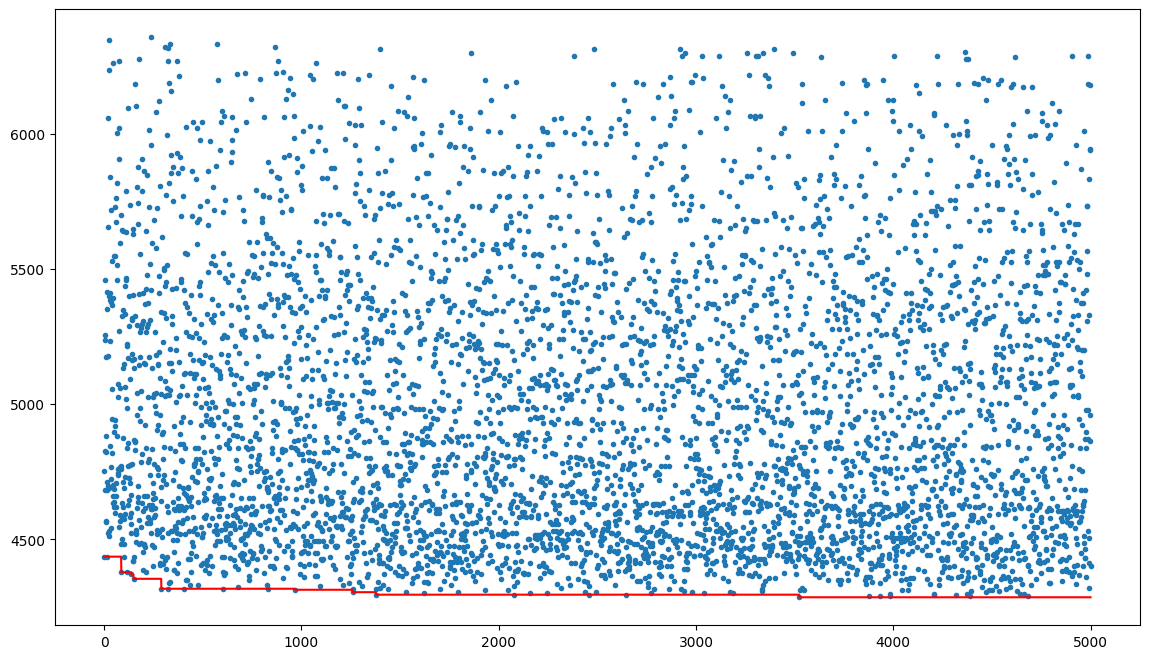

In [55]:
solution = tsp.copy() #pick the greedy solution as the initial solution
initial_cost=compute_distance(tsp, distance_matrix)
history = [initial_cost]
print(f"Initial Cost: {initial_cost :.2f}km (greedy)")
for step in tqdm(range(MAX_STEPS)):
    new_solution= InversionMutation(solution)
    f=compute_distance(new_solution, distance_matrix)
    history.append(f)
    if f < compute_distance(solution, distance_matrix):
        solution = new_solution
    else:
        temperture = 1 - step/MAX_STEPS
        #pick the worsen solution with a probability that decreases with the temperture
        #the formula is the opposite than the original one (e^(-delta/T)) because we want to minimize the cost so a worsen solution has a negative delta
        if np.random.random() < np.exp(-(f-compute_distance(solution,distance_matrix))/temperture):
            print("pick worsen solution wih f=",f)
            solution = new_solution
    
print (f"Final Cost: {compute_distance(solution, distance_matrix):.2f}km")
print (f"Final Steps: {len(solution)-1}")

plot_history(history)

### Evolutionary Algorithm

In [41]:

@dataclass
class Individual:
    genome: np.ndarray
    fitness: float = None


def invertOverCrossOver(p1: Individual,p2:Individual):
    p1=p1.genome
    p2=p2.genome
    offspring=[-1]*len(p1)
    index=np.random.randint(0,len(p1))#take a random index
    gene1=p1[index]#take the gene at that index
    indexP2_G1=p2.index(gene1)#find the index of the gene1 in the second parent
    indexP2_G2=(indexP2_G1+1)%len(p1)
    gene2=p2[indexP2_G2]#take the gene that follows gene1 in the second parent
    j=0
    for i in range(len(p1)):
        if p1[i]!=gene2:
            offspring[j]=p1[i]
            j+=1
        if p1[i]==gene1:
            offspring[j]=gene2
            j+=1
    return Individual(offspring)

def EA_mutate(individual: Individual):
    return Individual(InversionMutation(individual.genome))

def parent_selection(population):
    candidates = sorted(np.random.choice(population, 2), key=lambda e: e.fitness, reverse=True)
    return candidates[0]


Start with a population created by mutations of the greedy solution

100%|██████████| 500/500 [03:21<00:00,  2.48it/s]

Final Cost: 4258.07km
Final Steps: 45


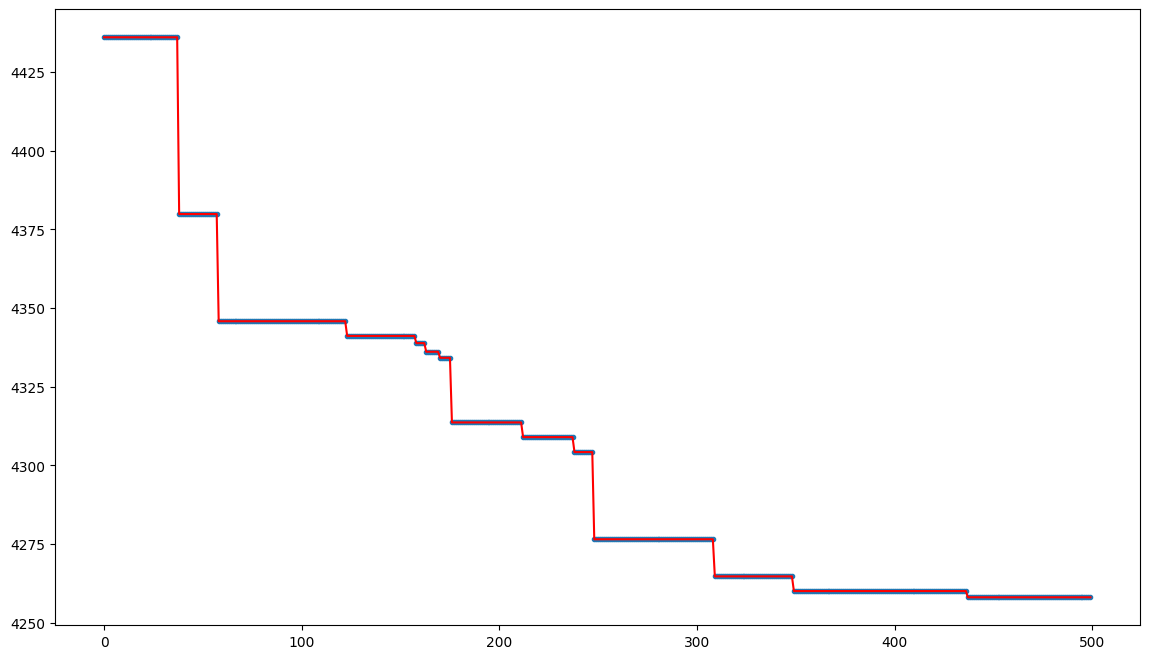

In [56]:
POPULATION_SIZE = 1000
population = [Individual(ScrambleMutation(tsp)) for _ in range(POPULATION_SIZE)]
for i in population:
    i.fitness = compute_distance(i.genome, distance_matrix)

history = []
OFFSPRING_SIZE = 400# if it is lower than population_Size the approch must be steady state because in case of generational the population at the next iteration will be composed by offsprings-> impossible because there are less than the population size
GENERATIONS=500

for g in tqdm(range(GENERATIONS)):
    offspring = list()
    

    for _ in range(OFFSPRING_SIZE):
        #hypermodern approach: mutation or crossover
        if np.random.random() <  .3:
            offspring.append(EA_mutate(parent_selection(population)))
        else:
            i1 = parent_selection(population)
            i2 = parent_selection(population)
            o = invertOverCrossOver(i1, i2)
            offspring.append(o)

    for i in offspring:
        i.fitness = compute_distance(i.genome,distance_matrix)

    population.extend(offspring)
    population.sort(key=lambda i: i.fitness)
    population = population[:POPULATION_SIZE]
    history.append(population[0].fitness)
print (f"Final Cost: {population[0].fitness:.2f}km")
print (f"Final Steps: {len(solution)-1}")

plot_history(history)